## Observations

Month is not a useful variable. Try Quarter.
Best result so far is decision tree with df[['Exterior Wall', 'Fixtures', 'Neighborhood', 'Story Height', 'Assessment Ratio', 'Quarter']]

Lots of outliers here, try RandomForest

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')
import matplotlib.dates as mdates

In [2]:
df1=pd.read_csv('nashville_20190813150235.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

C:\Users\alehe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Testing the averaged assessment ratio idea.
df['Assessment Ratio'] = df['Assessment Land Improved'] / df['Total Appraisal Value Improved']
nbhdratio=df.groupby('Neighborhood')['Assessment Ratio'].mean().to_frame().rename(columns={'Assessment Ratio':'Nbhd Ratio'})
df=df.merge(nbhdratio, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
#df = df[(df.Neighborhood != '9527') & (df.Neighborhood != '9026')]

In [7]:
df['PPS'].quantile([.9, .95, .998])

0.900     267.710176
0.950     319.003682
0.998    1255.281319
Name: PPS, dtype: float64

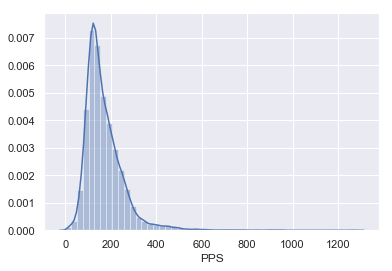

In [8]:
df=df[df.PPS <= 1300]
sns.distplot(df['PPS'].dropna())

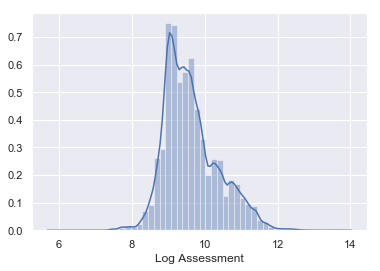

In [24]:
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
sns.distplot(df['Log Assessment'].dropna())

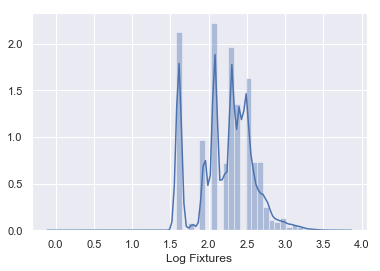

In [9]:
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
sns.distplot(df['Log Fixtures'].dropna())

In [ ]:
sns.distplot(df['Fixtures'].dropna())

In [10]:
np.std(df.PPS)

89.58656452443442

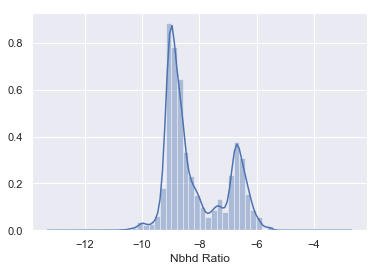

In [23]:
sns.distplot(np.log(df['Nbhd Ratio']**3))

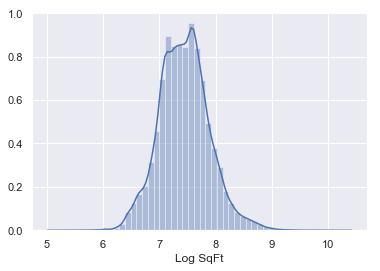

In [11]:
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
sns.distplot(df['Log SqFt'].dropna())

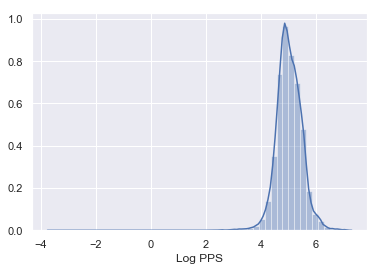

In [12]:
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log PPS']=df['Log PPS'].replace(np.inf, np.nan)
sns.distplot(df['Log PPS'].dropna())

In [13]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import train_test_split

In [39]:
df2 = df[['Exterior Wall','Log Fixtures','Building Type Custom', 'Log SqFt', 'Neighborhood', 'Log PPS', 'Log Assessment', 'Quarter']].dropna()
X= pd.get_dummies(df2[['Exterior Wall', 'Neighborhood','Building Type Custom', 'Log Fixtures','Log SqFt', 'Log Assessment', 'Quarter']])
y=df2['Log PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [16]:
df2.shape

(54198, 8)

In [36]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
dr=model.fit(X_train, y_train)
y_pred= dr.predict(X_test)
print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)

88.96616633190685


In [37]:
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)

56.992128255341925


In [29]:
np.exp(y_test).mean()

170.19746557132845

In [31]:
np.exp(y_test).std()

86.87522462124949

In [40]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)

C:\Users\alehe\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


43.89461030931045


### GridSearchCV didn't get as good results as untuned RandomForest.

In [43]:
# Number of trees in random forest
n_estimators = [100,150]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [6,7,8]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]

random_grid = {'n_estimators': n_estimators,
#                'max_features': 'auto',
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [44]:
from sklearn.model_selection import GridSearchCV
rfgrid = GridSearchCV(estimator = model, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_r = rfgrid.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.8min


KeyboardInterrupt: 

In [ ]:
rfgrid.best_params_

In [ ]:
rfgrid.best_score_ 

In [ ]:
np.exp(rfgrid.best_score_ )